# Contextual Bandits with Fairness Analysis

## Resampled dataset

In [1]:
import pandas as pd
import numpy as np
from contextualbandits.online import LinUCB
from sklearn.preprocessing import StandardScaler

# === 1. Load and prepare data ===
df = pd.read_csv("../data/Xy_train_resampled.csv")

X = df.drop(columns=['num']).values
y = df['num'].astype(int).values

# === 2. Initialize contextual bandit policy ===
n_actions = len(np.unique(y))  # type: ignore # should be 5 (0–4)
policy = LinUCB(nchoices=n_actions, alpha=0.3)

# === 3. Simulate online learning ===
preds, rewards = [], []

for i in range(len(X)):
    x_i = X[i].reshape(1, -1)  # needs 2D input
    true_label = y[i]

    # Predict (returns action indices)
    chosen_action = policy.predict(x_i)[0] # type: ignore

    # Reward: 1 if correct, else 0
    reward = int(chosen_action == true_label)

    # Update policy with this sample
    policy.partial_fit(x_i, np.array([chosen_action]), np.array([reward]))

    preds.append(chosen_action)
    rewards.append(reward)

# === 4. Store results ===
results = pd.DataFrame({
    "true_label": y,
    "predicted": preds,
    "reward": rewards
})

print("✅ Simulation complete")
print(f"Approx. accuracy on train data: {np.mean(results['true_label'] == results['predicted']):.3f}")


✅ Simulation complete
Approx. accuracy on train data: 0.534


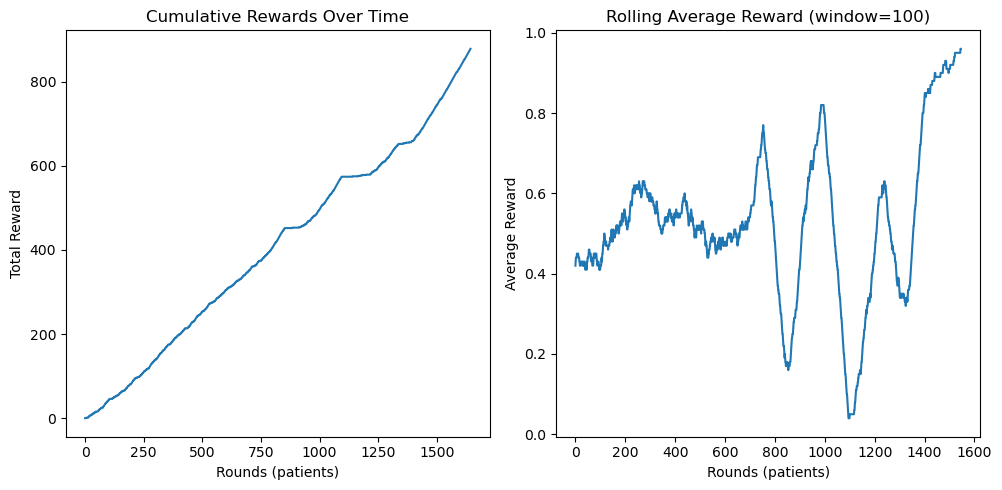

In [2]:
import numpy as np
import matplotlib.pyplot as plt

rewards = (preds == y).astype(int)  # 1 = correct prediction, 0 = incorrect

# Cumulative rewards over time
cumulative_rewards = np.cumsum(rewards)

# Rolling average reward (for smoother curve)
window = 100
rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Time")
plt.xlabel("Rounds (patients)")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(rolling_avg)
plt.title(f"Rolling Average Reward (window={window})")
plt.xlabel("Rounds (patients)")
plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()



In [3]:
from sklearn.metrics import accuracy_score

X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

preds_test = policy.predict(X_test)

score = accuracy_score(y_test, preds_test)

print("accuracy on test data: ", score)


accuracy on test data:  0.358695652173913


### Fairness evaluation on train data

In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

df = pd.read_csv("../data/Xy_train_resampled.csv")

df["pred"] = preds       
df["true"] = df["num"]   # ground truth

# Protected attribute
protected_attr = "sex_Male"  # since it's 0/1 after encoding
groups = df[protected_attr].unique()

metrics = {}
for g in groups:
    group_df = df[df[protected_attr] == g]
    acc = accuracy_score(group_df["true"], group_df["pred"])
    rec = recall_score(group_df["true"], group_df["pred"], average="macro")  # across all 5 classes
    metrics[g] = {"accuracy": acc, "recall": rec}

metrics_df = pd.DataFrame(metrics).T
metrics_df.index = ["Female (0)", "Male (1)"]
print(metrics_df)


            accuracy    recall
Female (0)  0.519673  0.532863
Male (1)    0.597315  0.513708


#### Statistical significance tets

In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest


male_mask = df["sex_Male"] == 1
female_mask = df["sex_Male"] == 0


y_true_male = df.loc[male_mask, 'true']
y_pred_male = df.loc[male_mask, 'pred']
y_true_female = df.loc[female_mask, 'true']
y_pred_female = df.loc[female_mask, 'pred']

assert((len(y_true_male) + len(y_true_female)) == (len(y_pred_male) + len(y_pred_female)))

acc_male = (y_pred_male == y_true_male.to_numpy().ravel()).astype(int)
acc_female = (y_pred_female == y_true_female.to_numpy().ravel()).astype(int)


count = np.array([acc_male.sum(), acc_female.sum()])  # number of correct predictions
nobs = np.array([len(acc_male), len(acc_female)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.5f}")

if pval < 0.05:
    print('accuracy difference significant')


z = -2.431, p = 0.01505
accuracy difference significant


### Fairness evaluation on test data

In [6]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

preds_test = policy.predict(X_test)


X_test["pred"] = preds_test       
X_test["true"] = y_test   # ground truth

# Protected attribute
protected_attr = "sex_Male"  # since it's 0/1 after encoding
groups = X_test[protected_attr].unique()

metrics = {}
for g in groups:
    group_df = X_test[X_test[protected_attr] == g]
    acc = accuracy_score(group_df["true"], group_df["pred"])
    rec = recall_score(group_df["true"], group_df["pred"], average="macro")  # across all 5 classes
    metrics[g] = {"accuracy": acc, "recall": rec}

metrics_df = pd.DataFrame(metrics).T
metrics_df.index = ["Female (0)", "Male (1)"] # type: ignore
print(metrics_df)


            accuracy    recall
Female (0)  0.296053  0.318639
Male (1)    0.656250  0.198148


/opt/miniconda3/envs/fariness-analysis-rl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


#### Statistical significance test

In [7]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest


male_mask = X_test["sex_Male"] == 1
female_mask = X_test["sex_Male"] == 0


y_true_male = y_test[male_mask]
y_pred_male = preds_test[male_mask]
y_true_female = y_test[female_mask]
y_pred_female = preds_test[female_mask]

assert((len(y_true_male) + len(y_true_female)) == (len(y_pred_male) + len(y_pred_female)))

acc_male = (y_pred_male == y_true_male.to_numpy().ravel()).astype(int)
acc_female = (y_pred_female == y_true_female.to_numpy().ravel()).astype(int)


count = np.array([acc_male.sum(), acc_female.sum()])  # number of correct predictions
nobs = np.array([len(acc_male), len(acc_female)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.5f}")

if pval < 0.05:
    print('accuracy difference significant')


z = -3.861, p = 0.00011
accuracy difference significant


## Original dataset

In [9]:
import pandas as pd
import numpy as np
from contextualbandits.online import LinUCB
from sklearn.preprocessing import StandardScaler

# === 1. Load and prepare data ===
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)

X = df.drop(columns=['num']).values
y = df['num'].astype(int).values

# === 2. Initialize contextual bandit policy ===
n_actions = len(np.unique(y))  # type: ignore # should be 5 (0–4)
policy = LinUCB(nchoices=n_actions, alpha=0.3)

# === 3. Simulate online learning ===
preds, rewards = [], []

for i in range(len(X)):
    x_i = X[i].reshape(1, -1)  
    true_label = y[i]

    # Predict (returns action indices)
    chosen_action = policy.predict(x_i)[0] # type: ignore

    # Reward: 1 if correct, else 0
    reward = int(chosen_action == true_label)

    # Update policy with this sample
    policy.partial_fit(x_i, np.array([chosen_action]), np.array([reward]))

    preds.append(chosen_action)
    rewards.append(reward)

# === 4. Store results ===
results = pd.DataFrame({
    "true_label": y,
    "predicted": preds,
    "reward": rewards
})

print("✅ Simulation complete")
print(f"Approx. accuracy on train data: {np.mean(results['true_label'] == results['predicted']):.3f}")


✅ Simulation complete
Approx. accuracy on train data: 0.510


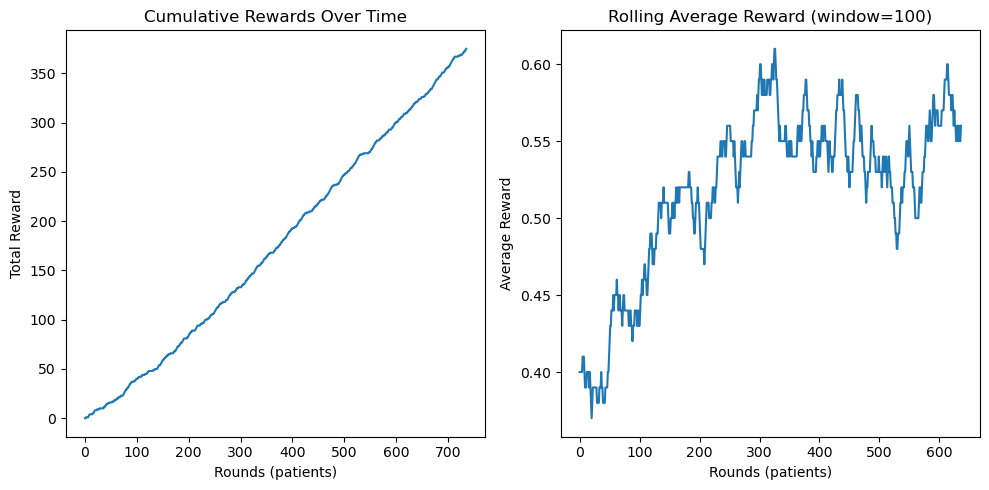

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# results = bandit.fit_predict(X, y)
# or evaluate(X, y)

rewards = (preds == y).astype(int)  # 1 = correct prediction, 0 = incorrect

# Cumulative rewards over time
cumulative_rewards = np.cumsum(rewards)

# Rolling average reward (for smoother curve)
window = 100
rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Time")
plt.xlabel("Rounds (patients)")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(rolling_avg)
plt.title(f"Rolling Average Reward (window={window})")
plt.xlabel("Rounds (patients)")
plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()



In [11]:
from sklearn.metrics import accuracy_score

X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

preds_test = policy.predict(X_test)

score = accuracy_score(y_test, preds_test)

print("accuracy on test data: ", score)


accuracy on test data:  0.5271739130434783


### Fairness evaluation on train data

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

# Load dataset and predictions
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)

# Add predictions from RL/bandit model
df["pred"] = preds       
df["true"] = df["num"]  

# Protected attribute
protected_attr = "sex_Male"  # since it's 0/1 after encoding
groups = df[protected_attr].unique()

metrics = {}
for g in groups:
    group_df = df[df[protected_attr] == g]
    acc = accuracy_score(group_df["true"], group_df["pred"])
    rec = recall_score(group_df["true"], group_df["pred"], average="macro")  # across all 5 classes
    metrics[g] = {"accuracy": acc, "recall": rec}

metrics_df = pd.DataFrame(metrics).T
metrics_df.index = ["Female (0)", "Male (1)"]
print(metrics_df)


            accuracy    recall
Female (0)  0.468641  0.324477
Male (1)    0.654321  0.246154


#### Statistical significance test

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score
from statsmodels.stats.proportion import proportions_ztest


male_mask = df["sex_Male"] == 1
female_mask = df["sex_Male"] == 0


y_true_male = df.loc[male_mask, 'true']
y_pred_male = df.loc[male_mask, 'pred']
y_true_female = df.loc[female_mask, 'true']
y_pred_female = df.loc[female_mask, 'pred']

assert((len(y_true_male) + len(y_true_female)) == (len(y_pred_male) + len(y_pred_female)))

acc_male = (y_pred_male == y_true_male.to_numpy().ravel()).astype(int)
acc_female = (y_pred_female == y_true_female.to_numpy().ravel()).astype(int)


count = np.array([acc_male.sum(), acc_female.sum()])  # number of correct predictions
nobs = np.array([len(acc_male), len(acc_female)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.10f}")

if pval < 0.05:
    print('accuracy difference significant')


z = -4.175, p = 0.0000298093
accuracy difference significant


### Fairness evaluation on test data

In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

preds_test = policy.predict(X_test)


X_test["pred"] = preds_test      
X_test["true"] = y_test   # ground truth

# Protected attribute
protected_attr = "sex_Male"  # since it's 0/1 after encoding
groups = X_test[protected_attr].unique()

metrics = {}
for g in groups:
    group_df = X_test[X_test[protected_attr] == g]
    acc = accuracy_score(group_df["true"], group_df["pred"])
    rec = recall_score(group_df["true"], group_df["pred"], average="macro")  # across all 5 classes
    metrics[g] = {"accuracy": acc, "recall": rec}

metrics_df = pd.DataFrame(metrics).T
metrics_df.index = ["Female (0)", "Male (1)"] # type: ignore
print(metrics_df)


            accuracy    recall
Female (0)  0.473684  0.325492
Male (1)    0.781250  0.284722


/opt/miniconda3/envs/fariness-analysis-rl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


#### Statistical significance

In [15]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest


male_mask = X_test["sex_Male"] == 1
female_mask = X_test["sex_Male"] == 0


y_true_male = y_test[male_mask]
y_pred_male = preds_test[male_mask]
y_true_female = y_test[female_mask]
y_pred_female = preds_test[female_mask]

assert((len(y_true_male) + len(y_true_female)) == (len(y_pred_male) + len(y_pred_female)))

acc_male = (y_pred_male == y_true_male.to_numpy().ravel()).astype(int)
acc_female = (y_pred_female == y_true_female.to_numpy().ravel()).astype(int)


count = np.array([acc_male.sum(), acc_female.sum()])  # number of correct predictions
nobs = np.array([len(acc_male), len(acc_female)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.5f}")

if pval < 0.05:
    print('accuracy difference significant')


z = -3.167, p = 0.00154
accuracy difference significant


## With age groups (original dataset)

In [16]:
pd.testing.assert_frame_equal(X_test.drop(columns=['pred', 'true']), pd.read_csv('../data/age_analysis/Xy_test_age_analysis.csv').drop(columns=['num', 'age_group']))
print("✅ The DataFrames are exactly the same.")

✅ The DataFrames are exactly the same.


In [17]:
df = pd.read_csv('../data/age_analysis/Xy_test_age_analysis.csv')
df.rename(columns={'num':'true'}, inplace=True)
df['pred'] = preds_test

In [18]:
accuracy_score(df['true'], df['pred'])

0.5271739130434783

In [19]:
from sklearn.metrics import accuracy_score, recall_score

results = {}

for group in df['age_group'].unique():
    mask = df['age_group'] == group
    y_true = df.loc[mask, 'true']
    y_pred = df.loc[mask, 'pred']

    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='macro')

    results[group] = {'accuracy': acc, 'recall': rec}

age_results = pd.DataFrame(results).T
order = [0, 3, 2, 1]
print(age_results.iloc[order])


       accuracy    recall
<40    0.777778  0.708333
40-50  0.833333  0.527778
50-60  0.512500  0.334365
60+    0.240000  0.207546


In [ ]:
df['age_group'].value_counts() # watch out - it is just test dataset

age_group
50-60    80
60+      50
40-50    36
<40      18
Name: count, dtype: int64

Test significance <40 and 40-50

In [21]:
mask_1 = df["age_group"] == '<40'
mask_2 = df["age_group"] == '40-50'


y_true_1 = df.loc[mask_1, 'true']
y_pred_1 = df.loc[mask_1, 'pred']
y_true_2 = df.loc[mask_2, 'true']
y_pred_2 = df.loc[mask_2, 'pred']

assert((len(y_true_1) + len(y_true_2)) == (len(y_pred_1) + len(y_pred_2)))

acc_1 = (y_pred_1.to_numpy().ravel() == y_true_1.to_numpy().ravel()).astype(int)
acc_2 = (y_pred_2.to_numpy().ravel() == y_true_2.to_numpy().ravel()).astype(int)

count = np.array([acc_1.sum(), acc_2.sum()])  # number of correct predictions
nobs = np.array([len(acc_1), len(acc_2)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.10f}")

if pval < 0.05:
    print('accuracy difference significant')
else:
    print('accuracy difference NOT significant')

z = -0.495, p = 0.6202940153
accuracy difference NOT significant


Test significance 40-50 AND 50-60

In [22]:
mask_1 = df["age_group"] == '40-50'
mask_2 = df["age_group"] == '50-60'


y_true_1 = df.loc[mask_1, 'true']
y_pred_1 = df.loc[mask_1, 'pred']
y_true_2 = df.loc[mask_2, 'true']
y_pred_2 = df.loc[mask_2, 'pred']

assert((len(y_true_1) + len(y_true_2)) == (len(y_pred_1) + len(y_pred_2)))

acc_1 = (y_pred_1.to_numpy().ravel() == y_true_1.to_numpy().ravel()).astype(int)
acc_2 = (y_pred_2.to_numpy().ravel() == y_true_2.to_numpy().ravel()).astype(int)

count = np.array([acc_1.sum(), acc_2.sum()])  # number of correct predictions
nobs = np.array([len(acc_1), len(acc_2)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.10f}")

if pval < 0.05:
    print('accuracy difference significant')
else:
    print('accuracy difference NOT significant')

z = 3.281, p = 0.0010354213
accuracy difference significant


Test significance 50-60 AND 60+

In [23]:
mask_1 = df["age_group"] == '50-60'
mask_2 = df["age_group"] == '60+'


y_true_1 = df.loc[mask_1, 'true']
y_pred_1 = df.loc[mask_1, 'pred']
y_true_2 = df.loc[mask_2, 'true']
y_pred_2 = df.loc[mask_2, 'pred']

assert((len(y_true_1) + len(y_true_2)) == (len(y_pred_1) + len(y_pred_2)))

acc_1 = (y_pred_1.to_numpy().ravel() == y_true_1.to_numpy().ravel()).astype(int)
acc_2 = (y_pred_2.to_numpy().ravel() == y_true_2.to_numpy().ravel()).astype(int)

count = np.array([acc_1.sum(), acc_2.sum()])  # number of correct predictions
nobs = np.array([len(acc_1), len(acc_2)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.10f}")

if pval < 0.05:
    print('accuracy difference significant')
else:
    print('accuracy difference NOT significant')

z = 3.076, p = 0.0020980507
accuracy difference significant
